In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split,ConcatDataset
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.models import resnet18,mobilenet_v3_large,MobileNet_V3_Large_Weights

import matplotlib.pyplot as plt
import json
import cv2
from PIL import Image
from model import SimpleCNN
from collections import Counter
from lion_pytorch import Lion 

# 0. Cấu hình chung

In [25]:
dataset_dir = 'data'
train_dir   = os.path.join(dataset_dir, 'train')
test_dir    = os.path.join(dataset_dir, 'Test_Alphabet')
batch_size  = 32
device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


#  1. Data Transforms & Augmentation 

In [26]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),      # lật ngang
    transforms.RandomRotation(15),         # xoay ±15°
    transforms.ColorJitter(
        brightness=0.3, contrast=0.3, saturation=0.3
    ),                                     # chỉnh sáng, tương phản, bão hòa
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

eval_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

#  2. Dataset & Dataloader 

In [49]:
full_train_dataset = ImageFolder(root=train_dir, transform=train_transform)
test_dataset       = ImageFolder(root=test_dir, transform=eval_transform)

+ Split train/validation

In [50]:
train_size = int(0.8 * len(full_train_dataset))
val_size   = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

+ Đảm bảo val dùng eval_transform

In [51]:
val_dataset.dataset.transform = eval_transform

# Lấy danh sách tên lớp
class_names = full_train_dataset.classes
num_classes = len(class_names)

print(f"Found {num_classes} classes: {class_names}")

Found 26 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


+ lưu class names

In [52]:
with open('sign_language_web/class_names.json','w', encoding='utf-8') as f:
    json.dump(class_names, f, ensure_ascii=False)

In [53]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4)

+ kiểm tra dataset có bị chênh lệch (mất cân bằng lớp) hay không

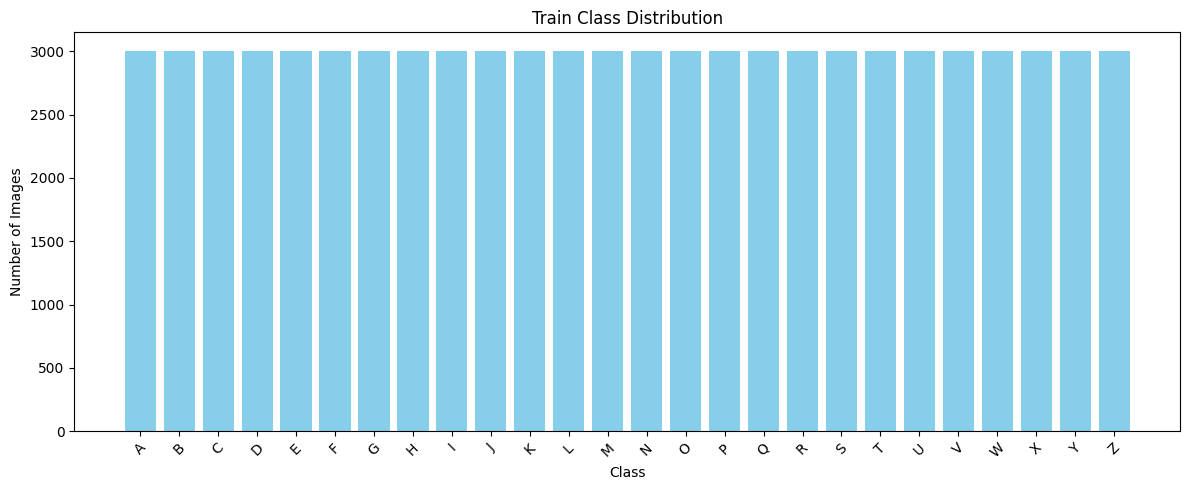

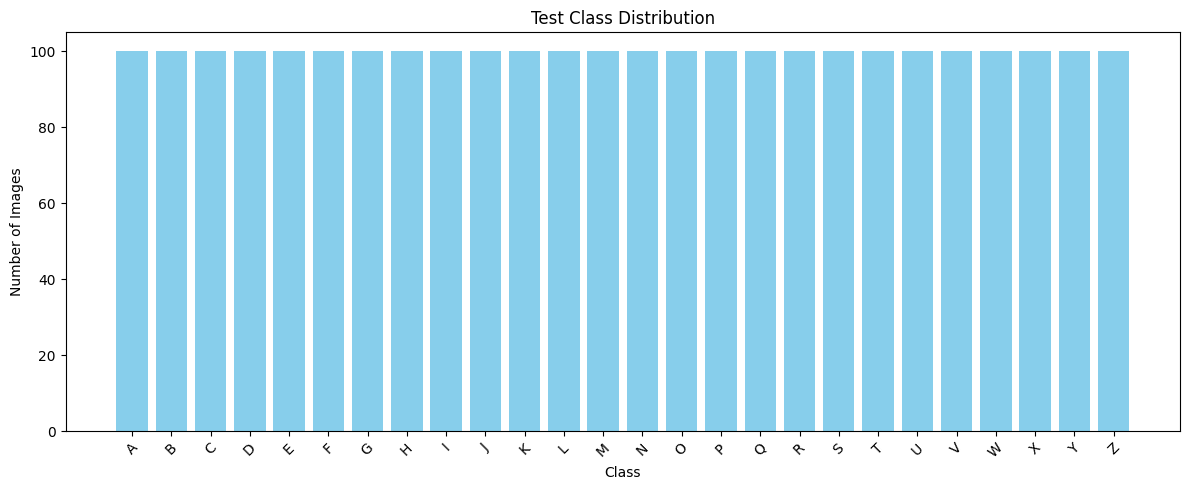

In [54]:
def check_class_distribution(imagefolder_dataset, title="Class Distribution"):
    # Đếm số lượng ảnh trên từng class
    labels = [label for _, label in imagefolder_dataset.imgs]
    counter = Counter(labels)

    # Map label index → tên class
    idx_to_class = {v: k for k, v in imagefolder_dataset.class_to_idx.items()}
    classes = [idx_to_class[i] for i in range(len(counter))]

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 5))
    plt.bar(classes, [counter[i] for i in range(len(classes))], color='skyblue')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


check_class_distribution(full_train_dataset, "Train Class Distribution")
check_class_distribution(test_dataset,        "Test Class Distribution")

In [33]:
# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, base_dataset, target_label, max_samples=None):
#         self.base = base_dataset
#         self.idx = [i for i,(_,lbl) in enumerate(base_dataset) if lbl==target_label]
#         if max_samples:  # Giới hạn số lượng augment nếu cần
#             self.idx = self.idx[:max_samples]
#         self.aug = transforms.Compose([
#             transforms.Resize((64,64)),
#             transforms.RandomRotation(30),
#             transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
#             transforms.ColorJitter(brightness=0.5),
#             transforms.ToTensor(),
#             transforms.Normalize((0.5,)*3,(0.5,)*3)
#         ])
#     def __len__(self): return len(self.idx)
#     def __getitem__(self, i):
#         img, lbl = self.base[self.idx[i]]
#         return self.aug(img), lbl


In [34]:
# base_eval = ImageFolder(root=train_dir, transform=eval_transform)

# frequent_confused = ['A','C','D','E','F','G','H','I','J','K','L','M','N','P','R','S','T','U','V','W','X','Y','Z']
# confused_idx = [class_names.index(cls) for cls in frequent_confused]

# aug_datasets = [CustomDataset(base_eval, idx, max_samples=500) for idx in confused_idx]

# # ✅ Gộp augment vào train_dataset
# train_dataset = ConcatDataset([train_dataset] + aug_datasets)

# # ✅ Tạo lại train_loader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


# 3. Model Definition (CNN with BatchNorm)

+ Khởi tạo model CNN

In [35]:
model = SimpleCNN(num_classes).to(device)

In [36]:
# Nếu muốn dùng ResNet18 pretrained, bỏ comment khối này và comment CNN trên:
# model = resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, num_classes)
# model = model.to(device)


In [ ]:
# weights = MobileNet_V3_Large_Weights.DEFAULT
# model = mobilenet_v3_large(weights=weights)
# model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
# model = model.to(device)

# 4. Loss, Optimizer, Scheduler 

In [37]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal.mean()


In [ ]:
# criterion = FocalLoss()
criterion = nn.CrossEntropyLoss()  
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = Lion(model.parameters(), lr=0.001, betas=(0.9, 0.99), weight_decay=1e-2)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

c:\Users\123ch\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# 5. Training Loop

In [39]:
epochs = 5
train_acc_history = []
val_acc_history   = []

for epoch in range(1, epochs+1):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss    = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        correct += (preds==labels).sum().item()
        total   += labels.size(0)
    train_acc = correct/total
    train_acc_history.append(train_acc)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs,1)
            correct += (preds==labels).sum().item()
            total   += labels.size(0)
    val_acc = correct/total
    val_acc_history.append(val_acc)

    # Step scheduler
    scheduler.step(val_acc)
    print(f"Epoch {epoch}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Lưu model sau train cơ bản
os.makedirs('sign_language_web', exist_ok=True)
torch.save(model.state_dict(), 'sign_language_web/sign_language_model_cnn.pth')
print("Model saved to sign_language_web/sign_language_model_cnn.pth")


Epoch 1/10 - Train Acc: 0.7580, Val Acc: 0.8854
Epoch 2/10 - Train Acc: 0.8303, Val Acc: 0.8876
Epoch 3/10 - Train Acc: 0.8176, Val Acc: 0.8849
Epoch 4/10 - Train Acc: 0.8234, Val Acc: 0.8824
Epoch 5/10 - Train Acc: 0.7950, Val Acc: 0.8735
Epoch 6/10 - Train Acc: 0.7695, Val Acc: 0.7959
Epoch 7/10 - Train Acc: 0.7786, Val Acc: 0.8659
Epoch 8/10 - Train Acc: 0.8054, Val Acc: 0.8731
Epoch 9/10 - Train Acc: 0.8250, Val Acc: 0.8665
Epoch 10/10 - Train Acc: 0.8258, Val Acc: 0.8812
Model saved to sign_language_web/sign_language_model_cnn.pth


# 6. Đánh giá trên Test Set

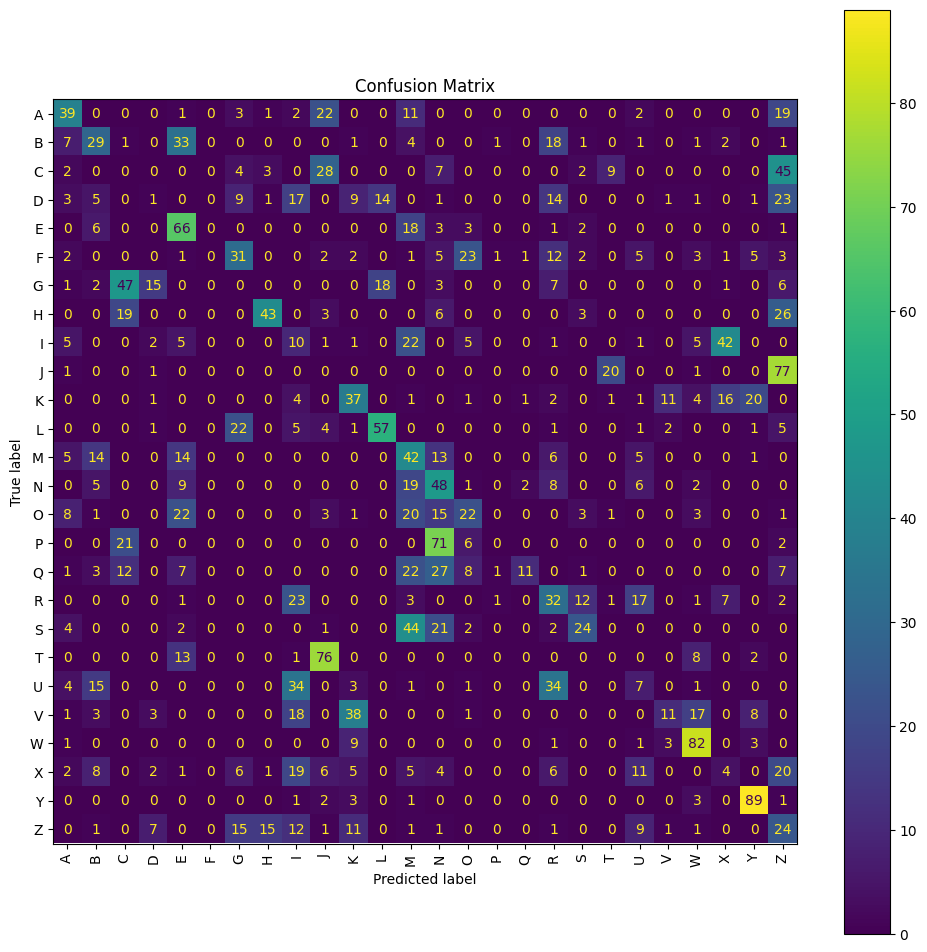

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Tạo figure có kích thước tùy chỉnh
fig, ax = plt.subplots(figsize=(12, 12))  # tùy chỉnh kích thước ở đây
disp.plot(ax=ax, xticks_rotation=90)

plt.title("Confusion Matrix")
plt.show()


In [56]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        correct += (preds==labels).sum().item()
        total   += labels.size(0)
print(f"Test Accuracy: {correct/total:.4f}")

Test Accuracy: 0.2608


# 7. Vẽ biểu đồ Accuracy 

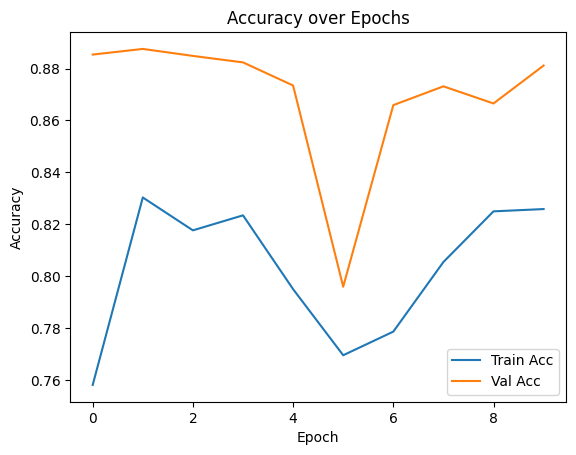

In [42]:
plt.figure()
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history,   label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.show()


In [43]:
# Đánh giá mô hình trên tập test
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"\n✅ Test Accuracy: {test_acc:.4f}")



✅ Test Accuracy: 0.2538


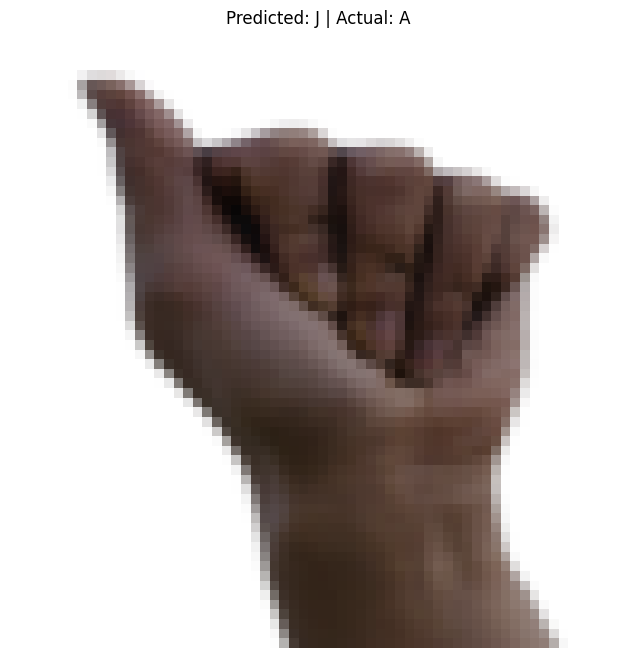

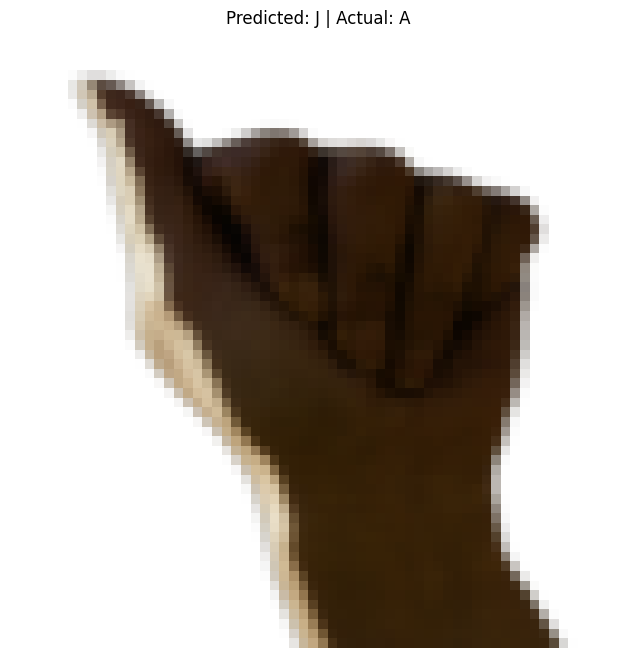

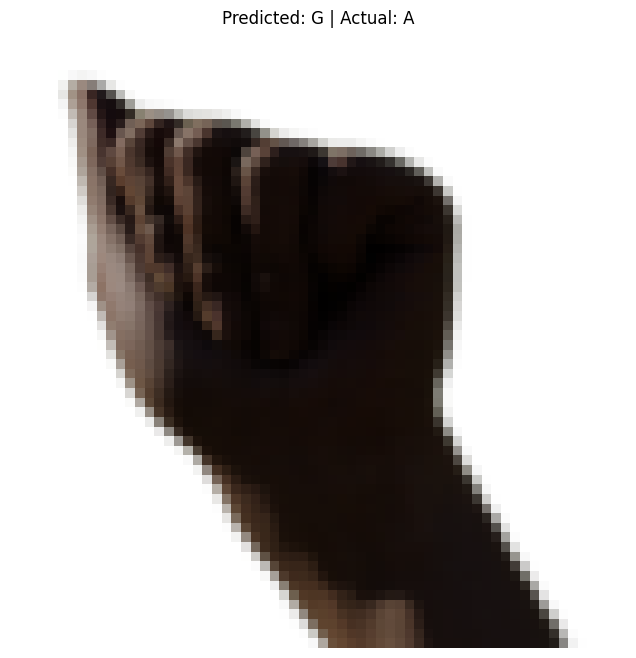

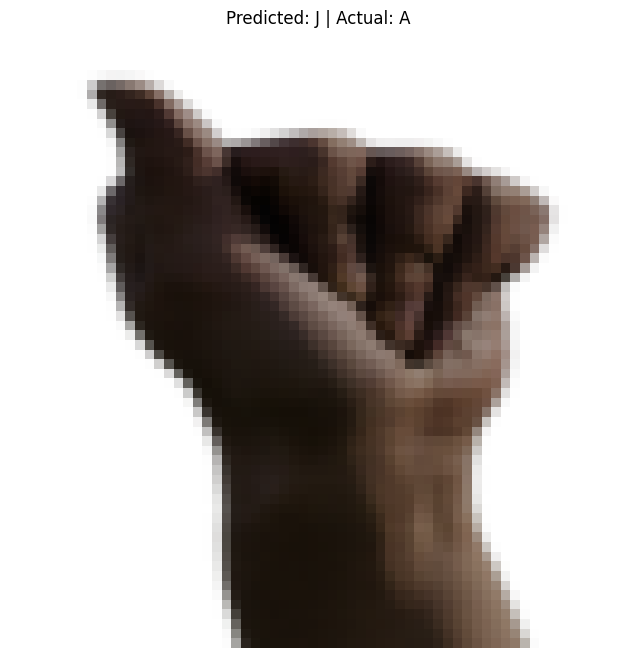

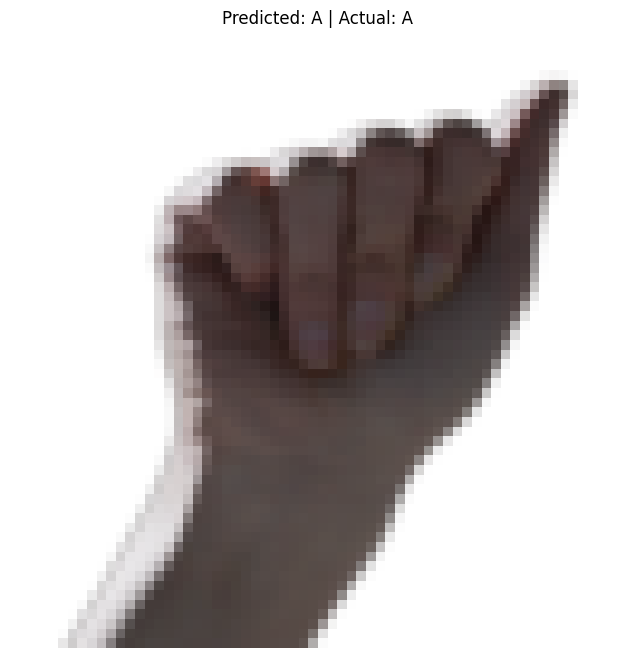

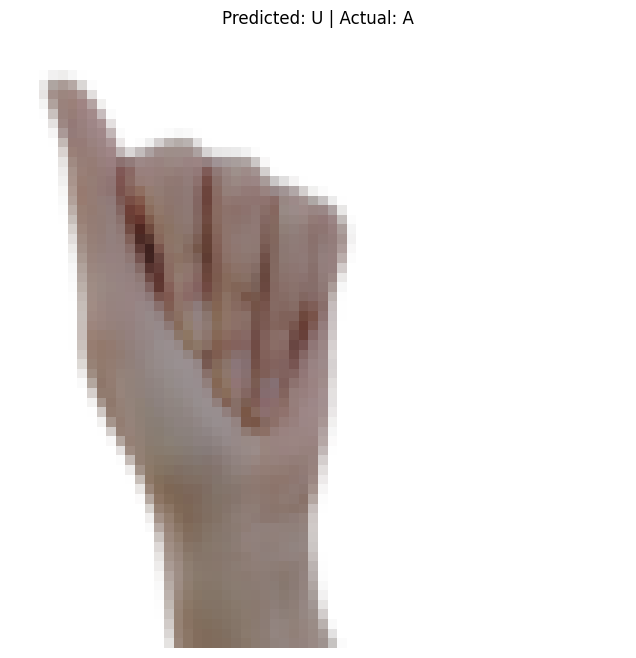

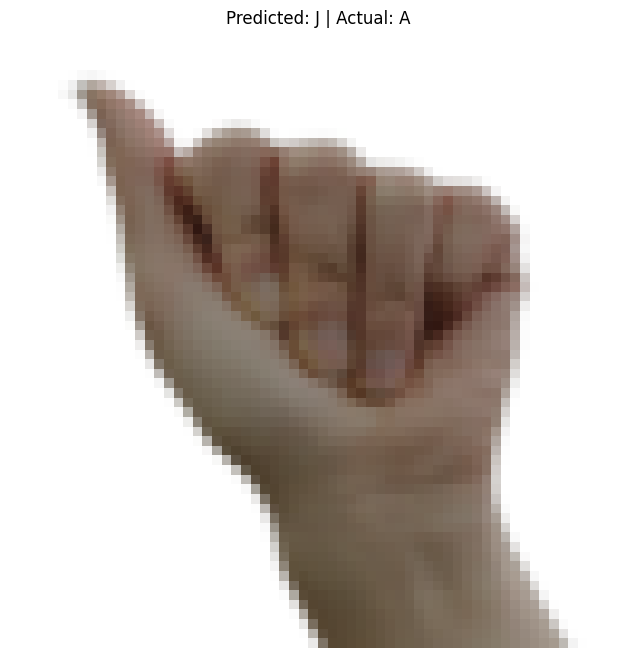

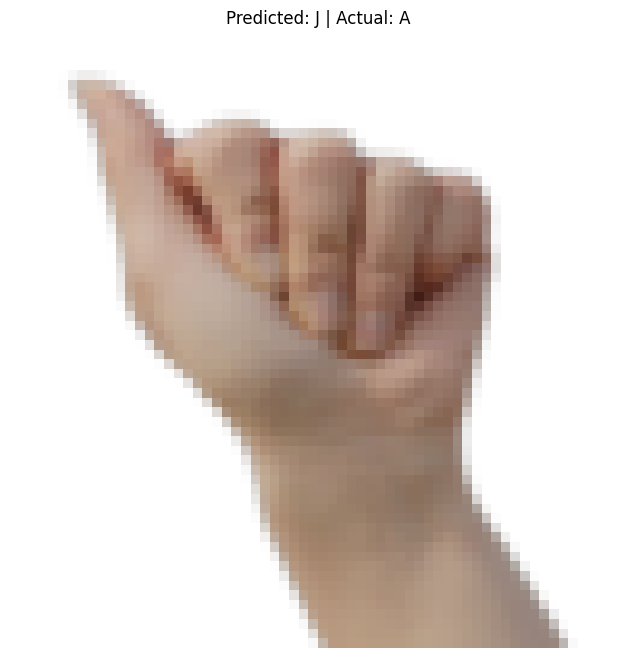

In [44]:
# Hiển thị một số ảnh từ tập test cùng nhãn dự đoán
import numpy as np

def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Lấy một batch ảnh từ test_loader
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Dự đoán
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Hiển thị 8 ảnh đầu tiên với nhãn dự đoán
for i in range(8):
    imshow(images[i], f"Predicted: {class_names[predicted[i]]} | Actual: {class_names[labels[i]]}")


Tổng số ảnh dự đoán sai: 1940


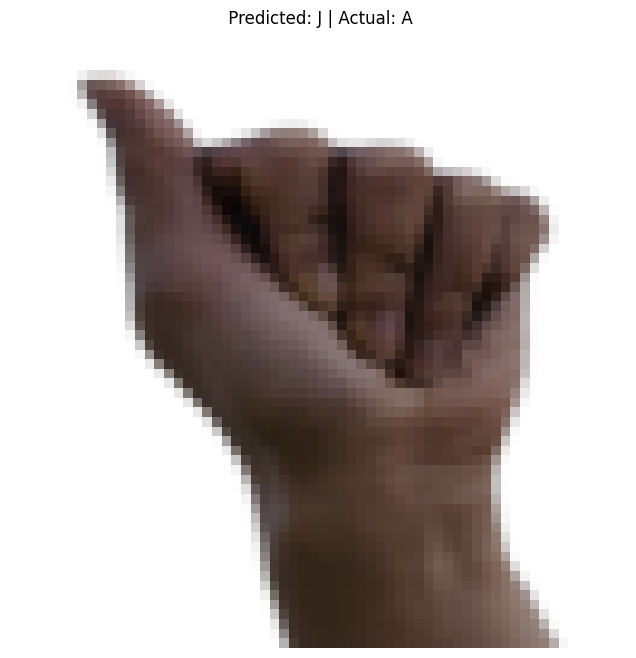

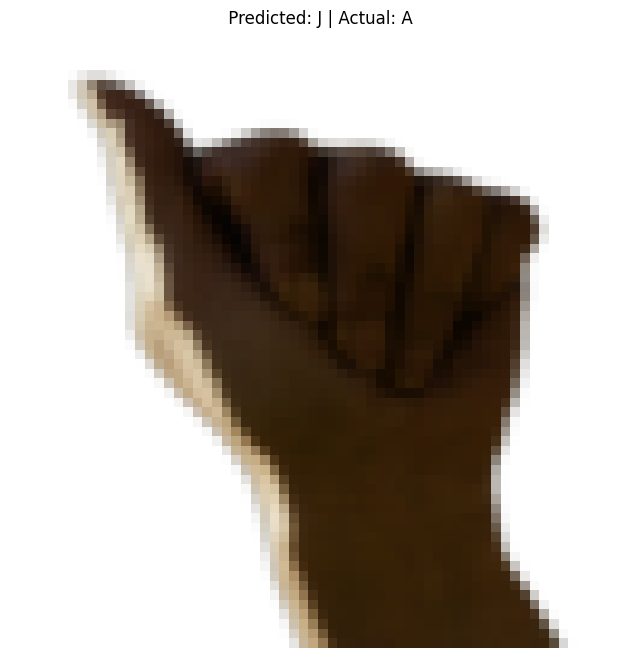

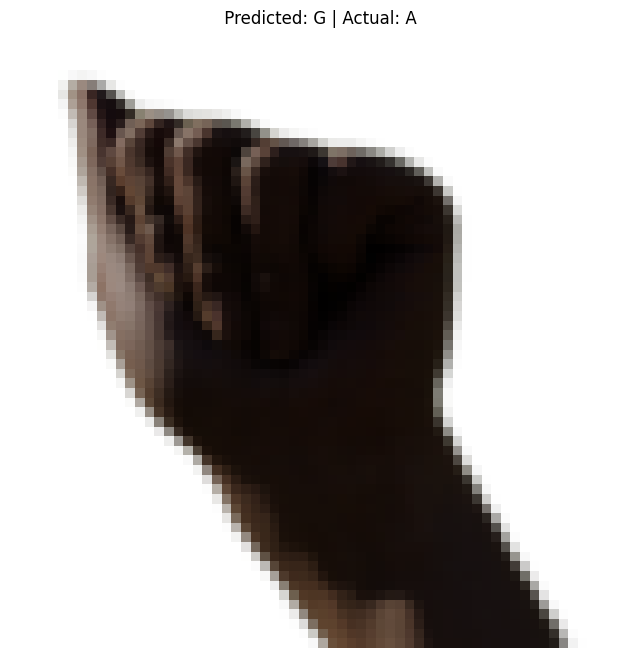

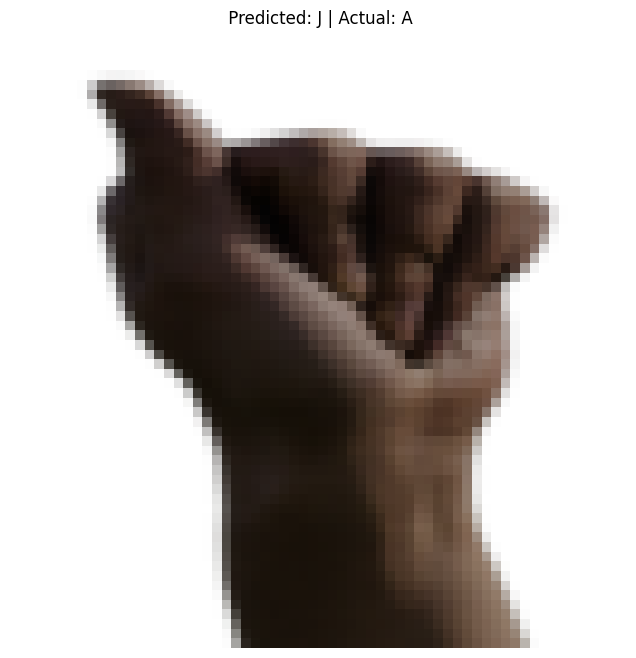

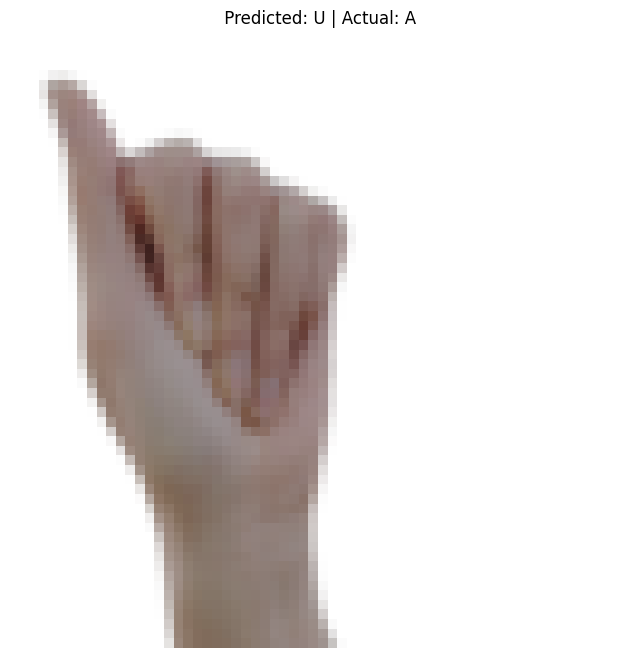

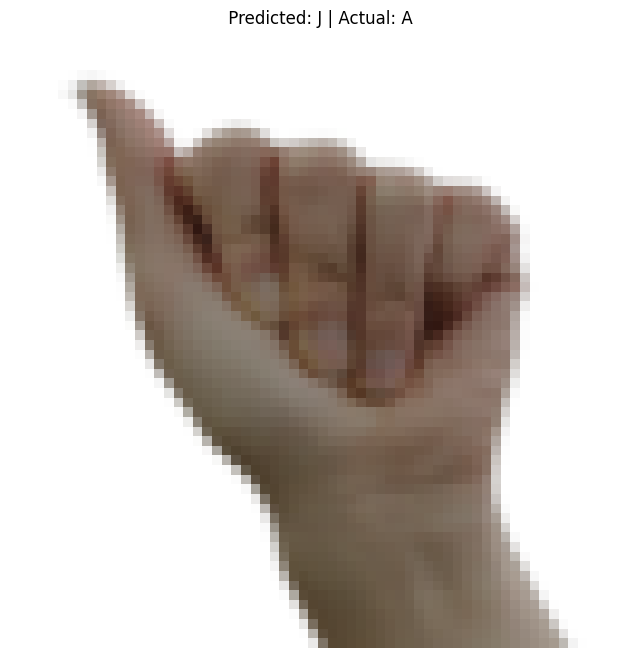

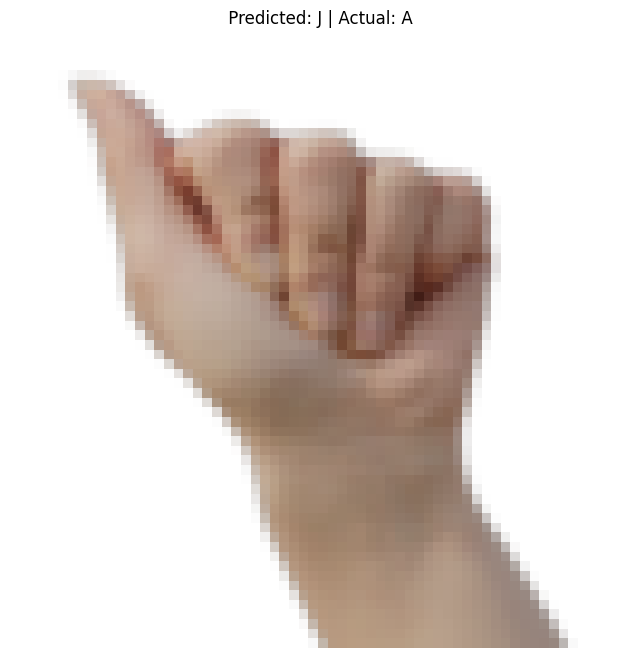

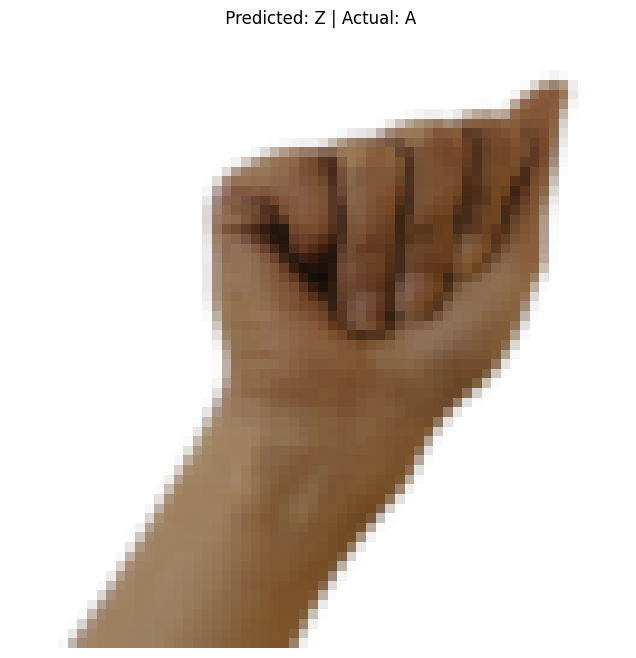

In [45]:
# Hiển thị các ảnh mà mô hình dự đoán sai
wrong_preds = []

# Lặp qua toàn bộ test_loader để tìm ảnh sai
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong_preds.append((images[i], preds[i], labels[i]))

# Hiển thị tối đa 8 ảnh sai
print(f"Tổng số ảnh dự đoán sai: {len(wrong_preds)}")
for i in range(min(8, len(wrong_preds))):
    img, pred_label, true_label = wrong_preds[i]
    imshow(img, f" Predicted: {class_names[pred_label]} | Actual: {class_names[true_label]}")
